### Import Dependencies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
# )

In [ ]:
# dataset = datasets.ImageFolder("Dataset", transform=transform)

In [ ]:
# dataset

In [8]:
!pip install rarfile  # Install the rarfile package if it's not already installed

import os
from rarfile import RarFile
from torchvision import transforms, datasets



# Define the path to the RAR file
rar_path = '/content/drive/MyDrive/Dataset.rar'

# Extract the RAR file to a temporary directory
with RarFile(rar_path, 'r') as rar:
    rar.extractall('/tmp/dataset')

# Define the transform to apply to the images
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Create the PyTorch dataset from the extracted images
dataset = datasets.ImageFolder('/tmp/dataset', transform=transform)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
dataset

Dataset ImageFolder
    Number of datapoints: 55448
    Root location: /tmp/dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [10]:
indices = list(range(len(dataset)))


In [11]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [12]:
validation = int(np.floor(0.70 * split))  # validation

In [13]:
print(0, validation, split, len(dataset))

0 32991 47130 55448


In [14]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :32991
length of validation size :14139
length of test size :22457


In [15]:
np.random.shuffle(indices)

### Split into Train and Test

In [16]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [17]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [18]:
targets_size = len(dataset.class_to_idx)

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [ ]:
# model = models.vgg16(pretrained=True)

In [ ]:
# for params in model.parameters():
#     params.requires_grad = False

In [ ]:
# model

In [ ]:
# n_features = model.classifier[0].in_features
# n_features

In [19]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [ ]:
# model

### Original Modeling

In [20]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
print(device)
device = torch.device("cuda")
print('Using GPU:', torch.cuda.get_device_name(0))

cuda
Using GPU: Tesla T4


In [23]:
model = CNN(targets_size)

In [24]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [25]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [26]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [27]:
def batch_gd(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in test_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [ ]:
# device = "cpu"

In [28]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [30]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 10
)

Epoch : 1/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:41.604614
Epoch : 2/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:44.822340
Epoch : 3/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:44.488231
Epoch : 4/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:44.083006
Epoch : 5/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:43.714151
Epoch : 6/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:44.816115
Epoch : 7/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:45.845728
Epoch : 8/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:45.888582
Epoch : 9/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:45.124338
Epoch : 10/10 Train_loss:0.000 Test_loss:0.000 Duration:0:04:45.867158


### Save the Model

In [31]:
torch.save(model.state_dict(), "plant_disease_model_1.pt")

### Load Model

In [38]:
targets_size = 1
model = CNN(targets_size)
model.load_state_dict(torch.load("/content/plant_disease_model_1.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
# %matplotlib notebook

<IPython.core.display.Javascript object>

### Plot the loss

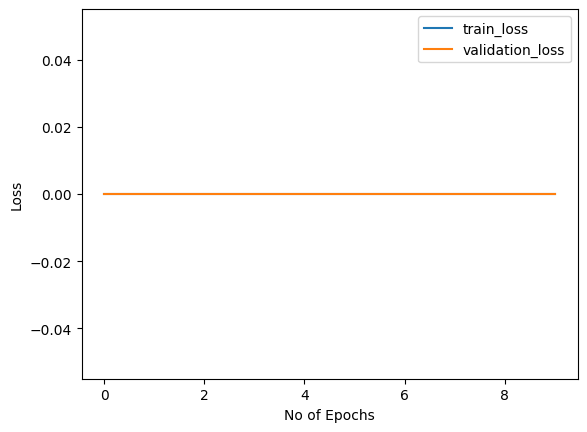

In [39]:
plt.plot(train_losses, label="train_loss")
plt.plot(validation_losses, label="validation_loss")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Accuracy

In [51]:
# def accuracy(loader):
#     n_correct = 0
#     n_total = 0

#     for inputs, targets in loader:
#         inputs, targets = inputs.cuda(), targets.cuda()

#         outputs = model(inputs)

#         _, predictions = torch.max(outputs, 1)

#         n_correct += (predictions == targets).sum().item()
#         n_total += targets.shape[0]

#     acc = n_correct / n_total
#     return acc
def accuracy(loader, model):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        model = model.cuda()
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

train_acc = accuracy(train_loader, model)
test_acc = accuracy(test_loader, model)
validation_acc = accuracy(validation_loader, model)



In [49]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

UnboundLocalError: ignored

In [52]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 1.0
Test Accuracy : 1.0
Validation Accuracy : 1.0


### Single Image Prediction

In [ ]:
transform_index_to_disease = dataset.class_to_idx

<IPython.core.display.Javascript object>

In [ ]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

<IPython.core.display.Javascript object>

In [ ]:
data = pd.read_csv("disease_info.csv", encoding="cp1252")

<IPython.core.display.Javascript object>

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

<IPython.core.display.Javascript object>

In [ ]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/Apple_ceder_apple_rust.JPG")

Original :  Apple_ceder_apple_rust
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

### Wrong Prediction

In [ ]:
single_prediction("test_images/Apple_scab.JPG")

Original :  Apple_scab
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/Grape_esca.JPG")

Original :  Grape_esca
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/apple_black_rot.JPG")

Original :  apple_black_rot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/apple_healthy.JPG")

Original :  apple_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/background_without_leaves.jpg")

Original :  background_without_leaves
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/blueberry_healthy.JPG")

Original :  blueberry_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  cherry_powdery_mildew
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_cercospora_leaf
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>

In [ ]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Cherry : Powdery Mildew


<IPython.core.display.Javascript object>